# black-box regression results

Generates figures comparing performance on the black-box regression problems.

In [1]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import os
sns.set(font_scale=1.25, style='whitegrid')

rdir = '../results/'
# figdir = 'figs/black-box' 
figdir = '../../paper/figs/results_pmlb_r1/'
# Set to path to PMLB datasets
datadir = '../../pmlb/datasets/'
print('figdir:',figdir)
def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    
symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',
    'FEAT',
    'EPLEX',
    'ClassicGP',
    'GP-GOMEA',
    'gpg (RT)',
    'gpg',
    '$\mathbf{gpg}$',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman',
    'DGSR-MCTS',
    'E2ET',
    '$DGSR$-$MCTS$',
    '$E2ET$',
    'PySR',
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman',
    'DGSR-MCTS',
    'E2ET',
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'ClassicGP',
    'gpg (RT)',
    'gpg',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'PySR',
]

figdir: ../../paper/figs/results_pmlb_r1/


# read data from feather

In [2]:
df_results = pd.read_feather('../results/black-box_results_inclPierre.feather')
df_results.columns

Index(['level_0', 'index', 'dataset', 'algorithm', 'random_state',
       'training time (s)', 'model_size', 'symbolic_model', 'mse_test',
       'mae_test', 'r2_test', 'params_str', 'training time (hr)',
       'r2_zero_test', 'friedman_dataset', 'symbolic_alg', 'mse_train',
       'mae_train', 'r2_train', 'predicted_tree'],
      dtype='object')

In [3]:
# ignore certain algos
#df_results = df_results[~df_results['algorithm'].isin(['gpg (RT)','ClassicGP', 'PySR'])]
# rename Pierre's methods, which were only tested on up to 10 dimensional-datasets
df_results.loc[df_results['algorithm'] == 'DGSR-MCTS', 'algorithm'] = '$DGSR$-$MCTS$'
df_results.loc[df_results['algorithm'] == 'E2ET', 'algorithm'] = '$E2ET$'

# rename gpg -> '$\mathbf{gpg}$',
df_results.loc[df_results['algorithm'] == 'gpg', 'algorithm'] = '$\mathbf{gpg}$'

## summarize results by dataset, including ranking

In [4]:
df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))

                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'])[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset')[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
###################
# save summary data
###################
df_sum.to_csv(rdir+'results_black-box_summary.csv.gz',compression='gzip',index=False)

df_sum

,algorithm,dataset,level_0,index,random_state,training time (s),model_size,mse_test,mae_test,r2_test,...,mae_test_rank,mae_test_norm,r2_test_rank,r2_test_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,$DGSR$-$MCTS$,1030_ERA,NaN,NaN,15795.0,NaN,47.0,NaN,NaN,0.389546,...,NaN,NaN,2.0,0.996518,NaN,NaN,NaN,NaN,NaN,NaN
1,$DGSR$-$MCTS$,1096_FacultySalaries,NaN,NaN,15795.0,NaN,33.0,NaN,NaN,-0.205755,...,NaN,NaN,26.0,0.749005,NaN,NaN,NaN,NaN,NaN,NaN
2,$DGSR$-$MCTS$,1199_BNG_echoMonths,NaN,NaN,15795.0,NaN,18.0,NaN,NaN,0.395940,...,NaN,NaN,22.0,0.933564,NaN,NaN,NaN,NaN,NaN,NaN
3,$DGSR$-$MCTS$,192_vineyard,NaN,NaN,15795.0,NaN,83.0,NaN,NaN,-0.168615,...,NaN,NaN,25.0,0.473291,NaN,NaN,NaN,NaN,NaN,NaN
4,$DGSR$-$MCTS$,218_house_8L,NaN,NaN,15795.0,NaN,30.0,NaN,NaN,0.503832,...,NaN,NaN,17.0,0.994994,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3144,gplearn,695_chatfield_4,24400.5,24400.5,13879.5,28398.484904,1.0,311.234213,11.696317,0.843542,...,2.0,0.000763,5.5,0.997885,5.5,0.974512,8.0,0.010673,8.0,0.038788
3145,gplearn,706_sleuth_case1202,24610.5,24610.5,13879.5,22506.032915,11.5,3185.450642,40.642813,0.661283,...,6.0,0.011345,3.0,0.999437,3.0,0.978553,5.0,0.009024,5.0,0.029265
3146,gplearn,712_chscase_geyser1,24820.5,24820.5,13879.5,26863.988673,3.0,36.237705,4.901875,0.760493,...,2.0,0.003243,5.0,0.995754,5.0,0.993841,1.0,0.000000,1.0,0.000000
3147,gplearn,banana,25030.5,25030.5,13879.5,31580.997657,33.5,0.421351,0.430139,0.571803,...,13.0,0.218451,16.0,0.898714,16.0,0.786982,16.0,0.158092,16.0,0.142943


# plot comparisons

In [5]:

def compare(df_compare, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[],**kwargs):
    plt.figure()
    order = df_compare.groupby(y)[x].median().sort_values(ascending=False).index
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    
    sns.catplot(data=df_compare, 
                kind='point',
#                 color='w',
                y=y,
                x=x,
                order=order,
                fliersize=0,
#                 notch=True,
                row=row,
                col=col,
                palette='flare_r',
                **kwargs
               )
    plt.ylabel('')
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)
    
    save(name='_'.join(['cat-boxplot',x + '-by-'+ y]) )
    if col:
        save(name='_'.join(['cat-boxplot',x + '-by-'+ y] + [col]) )

## point plot comparisons on PMLB

saving ../../paper/figs/results_pmlb_r1//pairgrid-pointplot_r2_test_model_size_training-time-(s).pdf


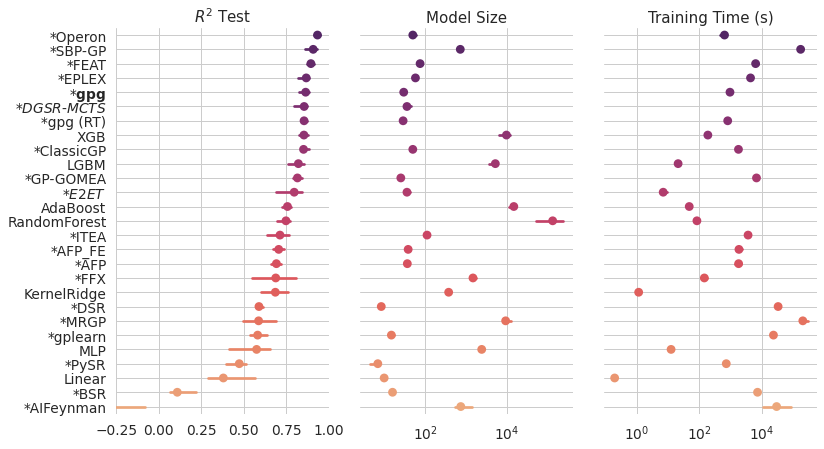

In [6]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
# different options
x_vars=[
#         'rmse_test',
#         'log_mse_test',
#         'r2_test_norm',
        'r2_test',
#        'r2_train',
#         'r2_test_rank',
        'model_size',
#         'model_size_rank',
        'training time (s)',
]
order = df_plot.groupby('*algorithm*')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['*algorithm*'],
                 height=6.5, 
                 aspect=0.6,
#                  hue='symbolic_dataset'
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      size=10,
      orient="h",
      jitter=False,
      order=order,
      palette="flare_r",
      linewidth=1,
      markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')

    if title == '$R^2$ Train':
        ax.set_xlim([0.75,1])

    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

save(name='_'.join(['pairgrid-pointplot']+x_vars))

### OVERALL SCORE (F1)

In [7]:
import numpy as np 

df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
# different options
df_plot["simplicity"] = (100-(df_plot["model_size"])).clip(0)
df_plot["simplicity"] = (df_plot["simplicity"] - df_plot["simplicity"].min())/(df_plot["simplicity"].max() - df_plot["simplicity"].min())
df_plot["normaliz_time"] = (-df_plot["training time (s)"])
df_plot["normaliz_time"] = (df_plot["normaliz_time"] - df_plot["normaliz_time"].min())/(df_plot["normaliz_time"].max() - df_plot["normaliz_time"].min())

df_plot["Harmonic"] = 2 / (1/df_plot["r2_test"] + 1/df_plot["simplicity"])
df_plot["Harmonic2"] = 2 / (1/df_plot["r2_test"] + 1/df_plot["normaliz_time"])
result = df_plot.groupby('*algorithm*')["Harmonic"].median().sort_values(
                    ascending=False).head(10)
print(result)
result = df_plot.groupby('*algorithm*')["Harmonic2"].median().sort_values(
                    ascending=False).head(10)
print(result)

*algorithm*
*$\mathbf{gpg}$    0.778634
*GP-GOMEA          0.775608
*gpg (RT)          0.772874
*DSR               0.717261
*gplearn           0.674360
*AFP               0.642898
*ClassicGP         0.634254
*AFP_FE            0.633932
*$E2ET$            0.633534
*PySR              0.626025
Name: Harmonic, dtype: float64
*algorithm*
*Operon            0.963340
*FEAT              0.932756
*$\mathbf{gpg}$    0.926324
XGB                0.921031
*gpg (RT)          0.920921
*EPLEX             0.917763
*ClassicGP         0.917745
*FFX               0.904193
LGBM               0.901907
*GP-GOMEA          0.889331
Name: Harmonic2, dtype: float64


## effect of friedman datasets

/export/scratch1/home/virgolin/anaconda3/envs/srbench/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)


saving ../../paper/figs/results_pmlb_r1//friedman_comparison_pairgrid-pointplot_normalized_R2_test.pdf


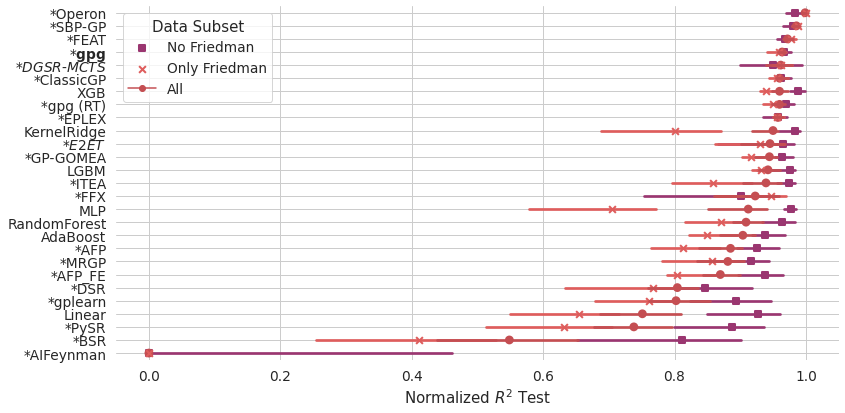

In [8]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['*algorithm*','r2_test','r2_test_norm','r2_test_rank','friedman_dataset']]

x='r2_test'
markers = ['o','s','x']
colors = sns.color_palette('flare',n_colors=3)
for x in ['r2_test_norm']:
    h = plt.figure(figsize=(12,6))
    ax = plt.gca()
    order = df_plot.groupby('*algorithm*')[x].median().sort_values(
                    ascending='r2' not in x or 'rank' in x).index
    i = 0
    axes = []
    g = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
                  hue='friedman_dataset',
                  size=10,
                  orient="h",
                  order=order,
                  markers=['s','x'],
                  palette="flare_r",
                  join=False,
                  estimator=np.median,
                  legend_out=True
                 )
    # all PMLB
    g2 = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
#                   hue='friedman_dataset',
                  size=10,
                  orient="h",
                  order=order,
                  color='r',
#                   palette="flare_r",
                  join=False,
                  estimator=np.median,
                  markers = ['o'],
                  legend_out=True
                 )
    # add all PMLB to legend
    handles, labels = ax.get_legend_handles_labels()
    #Create custom artists
    both = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='-', label='All')
    handles.append(both)
    plt.legend(title='Data Subset',
               handles=handles, 
               labels=['No Friedman','Only Friedman','All'])
    
    if x=='r2_test':
        plt.xlim([-.5,1.0])
    if 'norm' in x:
        x='normalized_R2_test'
    sns.despine(left=True, bottom=True)
#         plt.title(prefix.replace('_',' ').title())
    axes.append(ax)
    i+=1
    plt.tight_layout()
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel(x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$'))
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)


    save(name='friedman_comparison_'+'_'.join(['pairgrid-pointplot']+[x]))

# training time versus dataset size

In [9]:
if False:
    import pandas as pd
    # for dataset, dfg in df_sum.groupby('dataset'):
    def get_size(dataset,i):
        df = pd.read_csv(datadir+dataset+'/'+dataset+'.tsv.gz',sep='\t') 
        return df.shape[i]
    df_sum.loc[:,'dataset_nsamples'] = df_sum['dataset'].apply(lambda x: get_size(x,0))
    df_sum.loc[:,'dataset_nsamples_train'] = df_sum['dataset'].apply(lambda x: min(get_size(x,0),10000))
    df_sum.loc[:,'dataset_nfeatures'] = df_sum['dataset'].apply(lambda x: get_size(x,1))
    df_sum.loc[:,'dataset_npoints'] = df_sum['dataset_nsamples']*df_sum['dataset_nfeatures']
    df_sum

In [10]:
if False:
    df_sum['Method Family'] = df_sum['algorithm'].apply(lambda x: 'Operon' if x=='Operon' else 'XGB' if x=='XGB' else 'Other Non-GP SR' if x in nongp_algs else 'Other GP SR' if x in gp_algs else 'Other ML')
    sns.set_style('whitegrid')
    for col in ['dataset_nsamples_train','dataset_nsamples','dataset_nfeatures','dataset_npoints']:
        plt.figure(figsize=(8,8))
        ax = sns.lineplot(
            data=df_sum.loc[df_sum.algorithm.isin(['Operon',
                                                'FEAT',
                                                'EPLEX',
                                                'SBP-GP',
                                                'XGB',
                                                'DSR',
                                                ])],
            x = col,
            y = 'training time (hr)',
    #         hue='Method Family',
    #         style='Method Family',
            hue='algorithm',
            style='algorithm',
            markers=True,
            palette='cividis',
            markersize=10,
            markerfacecolor=None,
            err_style='bars',
            alpha=0.85
    #         facecolors=None
    #         scatter_kws = {'facecolors':'none'}
        )
        ax.set_yscale('log')
        ax.set_xscale('log')
    #     plt.legend(loc=[1.01,0])
        plt.xlabel(col.replace('_',' ').title())
        plt.ylabel('Training Time (hr)')
        save('training_time_'+col)

<!-- # scores on symbolic datasets (prelim) -->

# Pareto plot

Plot the method results as trade-offs between accuracy and simplicity

In [11]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

PF: [16, 8, 12, 2, 7, 15]
PF: [23, 19, 18, 10, 17]
PF: [6, 3, 4, 0, 9, 22, 26]
PF: [1, 21]
PF: [13]
PF: [11, 20]
PF: [5, 24, 25]
PF: [14]
saving ../../paper/figs/results_pmlb_r1//pareto_plot_r2_test_rank_model_size_rank.pdf


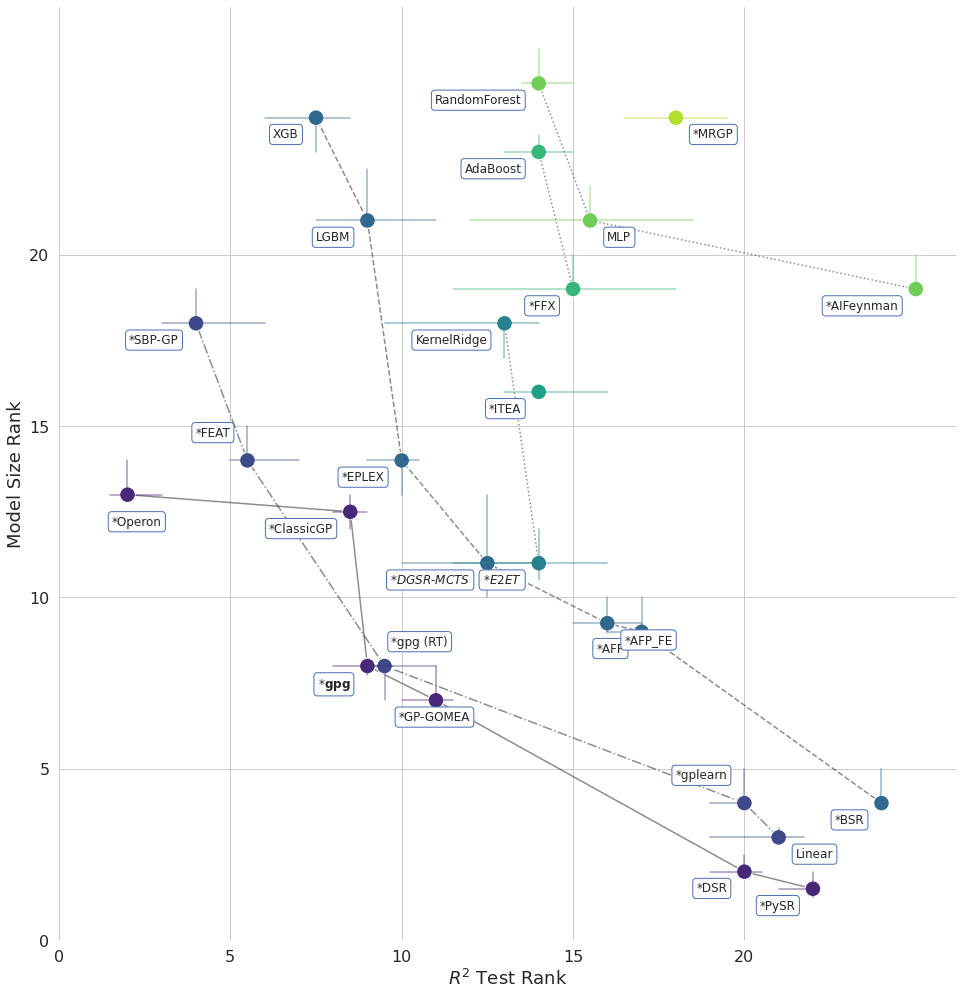

In [27]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=18
plt.figure(figsize=(14,14))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
xcol = 'r2_test_rank'
# xcol  = 'r2_test'
ycol = 'model_size_rank'
# ycol = 'model_size'
palette = 'viridis'
# outline pareto front
pareto_data = data.groupby('*algorithm*').median()

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
# objs[:,0] = -objs[:,0]
levels = 8
styles=['-','-.','--',':', ':', ':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

cmap = sns.color_palette(palette=palette, 
                         n_colors=pareto_data.pareto_rank.nunique(), 
                         desat=None, 
                         as_cmap=False)

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
#     data = data.groupby('*algorithm*').median(),
    data = pareto_data,
    x = xcol,
    y = ycol,
#     style='*algorithm*',
#     style='pareto_rank',
    hue = 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
xoff = .5
yoff = 0.3
# xoff, yoff = 0, 0
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear','*AFP_FE','MLP','*MRGP']:
        x=row[xcol]+xoff
        ha='left'
    elif idx == '*Operon':
        x = row[xcol]+1
        y -= yoff
    elif idx == "*GP-GOMEA":
        x = row[xcol]+1
    elif idx == "*gpg (RT)":
        ha = "left"
        y += 1.2
        x += .7
    elif idx in ['*gplearn','*FEAT']:
#         x -= xoff
#         x=row[xcol]+xoff
        y = row[ycol]+1
#         ha='left'
        
    plt.text(s=idx,
             x = x, 
             y = y,
             ha=ha,
             va='top',
             bbox=dict(facecolor='w', edgecolor='b', boxstyle='round', alpha=1)
            )
    
# confidence intervals
i = 0
for alg, dg in data.groupby('*algorithm*'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    i += 1
ax.set_aspect(1.0)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ticksize=16
plt.xticks([0,5,10,15,20],fontsize=ticksize)
plt.yticks([0,5,10,15,20],fontsize=ticksize)
# ax.set_yscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

In [13]:
objs

array([[inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [18., 24.],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf],
       [inf, inf]])

In [14]:
pareto_data['pareto_rank']

*algorithm*
*$DGSR$-$MCTS$     2.0
*$E2ET$            3.0
*$\mathbf{gpg}$    0.0
*AFP               2.0
*AFP_FE            2.0
*AIFeynman         6.0
*BSR               2.0
*ClassicGP         0.0
*DSR               0.0
*EPLEX             2.0
*FEAT              1.0
*FFX               5.0
*GP-GOMEA          0.0
*ITEA              4.0
*MRGP             -1.0
*Operon            0.0
*PySR              0.0
*SBP-GP            1.0
*gpg (RT)          1.0
*gplearn           1.0
AdaBoost           5.0
KernelRidge        3.0
LGBM               2.0
Linear             1.0
MLP                6.0
RandomForest       6.0
XGB                2.0
Name: pareto_rank, dtype: float64